In [388]:
import urllib.request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import widgets, interactive

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Fire Emblem: Heroes Character Analysis

## Introduction

In this project, we will be taking a look at character data from the popular mobile game *Fire Emblem: Heroes* available on iPhone and Android. Fire Emblem, a strategy RPG franchise developed by Intelligent System, added this mobile game to its list of entries following the popularity of recent titles *Fire Emblem: Awakening* and *Fire Emblem: Fates* for the 3DS. In this entry, you are in the position of a tactician, deploying up to four characters from the Fire Emblem Universe to do battle against the opposing enemy team. The game utilizes a rock-paper-scissors battle mechanic, with some weapons being superior to others. 

Like many popular mobile games, *Fire Emblem: Heroes* is a free-to-play Gacha game, where characters are drawn from a random pool, each with varying rarity and power. 

Note: This notebook shows most of the same analysis as Fire Emblem Heroes Scraping and Visualization. However, this notebook has the original scraping processes, using gamepedia.com data instead of gamepress.gg

## Web-Scraping

We begin this project by obtaining the character data, using data hosted on gamepedia.com (I do not own the data).

In [176]:
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

opener = Request("https://feheroes.gamepedia.com/Stats_Table",
                headers = {"User-Agent": "Mozilla/5.0"})

# query the website and return the html to the variable 'webpage'

webpage = urlopen(opener).read()

# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(webpage, 'html.parser')

In [177]:
# Take out the <div> of name and get its value
right_table=soup.find('table', id = "max-stats-table")
length = len(right_table.findAll("tr"))

# variable placeholders for respective column info for data frame
name = []
color = []
weapon_type = []
mov_type = []
hp = []
atk = []
spd = []
defense = []
res = []
total = []

#inserting values into the placeholders
i = 0
for row in right_table.findAll("tr"):
    if i == 0:
        i += 1
        continue
    val = []
    val = row["data-weapon-type"].split()
    color.append(val[0])
    weapon_type.append(val[1])
    mov_type.append(row["data-move-type"])
    cells = row.findAll('td')
    name.append(cells[0].findAll('a')[0]["title"])
    hp.append(int(cells[4].find(text=True)))
    atk.append(int(cells[5].find(text=True)))
    spd.append(int(cells[6].find(text=True)))
    defense.append(int(cells[7].find(text=True)))
    res.append(int(cells[8].find(text=True)))
    total.append(int(cells[9].find(text=True)))

In [178]:
# creating the data frame using pandas
df = pd.DataFrame(name,columns=['Name'])
df["Color"] = color
df['Weapon Type'] = weapon_type
df['Movement Type'] = mov_type
df['HP'] = hp
df['Attack'] = atk
df['Speed'] = spd
df['Defense'] = defense
df['Resistance'] = res
df['Total'] = total

This gives us a dataframe that details the battle-related statistics of each character, including their weapon type, movement type, and the values for each of their stats.

We will take a look at the dataframe for all the renditions of the character named Ike from *Fire Emblem: Path of Radiance* and *Fire Emblem: Radiant Dawn*.

In [179]:
df[df['Name'].str.contains("Hector")]

,Name,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
157,Hector: Brave Warrior,Blue,Lance,Armored,48,37,22,39,28,174
158,Hector: Dressed-Up Duo,Red,Sword,Armored,47,41,26,39,27,180
159,Hector: General of Ostia,Green,Axe,Armored,52,36,24,37,19,168
160,Hector: Just Here to Fight,Green,Axe,Armored,50,38,21,40,24,173
161,Hector: Marquess of Ostia,Green,Axe,Armored,47,40,23,38,26,174


However, there's more data that is involved with each character. We also would like to obtain information regarding what Fire Emblem game they are from originally, when the character was first introduced into FE Heroes, what rarities they are available at, how they can be obtained in the game, and whether they are one of the distinct "Legendary Heroes" or not (we will be doing an analysis on them later). We will be using another link from gamepedia.com to do so:

In [180]:
#grab universe from link
    
opener2 = Request("https://feheroes.gamepedia.com/Hero_list",
        headers = {"User-Agent": "Mozilla/5.0"})

# query the website and return the html to the variable 'webpage'

universe = urlopen(opener2).read()

# parse the html using beautiful soup and store in variable 'soup'
uni = BeautifulSoup(universe, 'html.parser')

left_table=uni.find('table')
length = len(left_table.findAll("tr"))

# variable placeholders for respective column info for data frame
nombre = []
origin = []
col = []
weap_type = []
move_type = []
rarities = []
st_tt = []
release = []
lgd = []
myt = []

tab_vals = left_table.findAll("tr")

for ind in range(1, len(tab_vals)):
    val = []
    val = tab_vals[ind]["data-weapon-type"].split()
    cells = tab_vals[ind].findAll("td")
    
    nombre.append(cells[1].findAll('a')[0]["title"])
    origin.append(cells[2].find(text=True))
    rare = (cells[5].findAll(text=True))
    add = []
    legend = False
    mythic = False
    for i in np.arange(len(rare)):
        app = "None"
        if str(rare[i]).find("–") != -1:
            rare[i] = str(rare[i]).replace("–", "")
        if rare[i].find(" ") != -1:
            rare[i] = str(rare[i]).replace(" ", "")
        if rare[i] == "TempestTrials":
            app = "Tempest Trials"
        if rare[i] == "GrandHeroBattle":
            app = "Grand Hero Battle"
        if rare[i] == "Story":
            app = "Story"
        if i + 1 == len(rare):
            st_tt.append(app)
        if rare[i] in ("3", "4", "5"):
            add.append(int(rare[i]))
        if rare[i] == "Legendary":
            legend = True
        if rare[i] == "Mythic":
            mythic = True
    lgd.append(legend)
    myt.append(mythic)
    rarities.append(add)
    release.append(cells[6].find(text=True))
    
    
# creating the data frame using pandas
df2 = pd.DataFrame(nombre,columns=['Name'])
df2["Origin"] = origin
df2['Rarities'] = rarities
df2['Story/TT/GHB?'] = st_tt
df2['Release Date'] = release
df2["Legendary"] = lgd
df2["Mythic"] = myt

Now we have our second dataframe which, when running the cell below, looks like this:

In [181]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', 100):
    display(df2)

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Mythic
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,False
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False,False
...,...,...,...,...,...,...,...
451,Zelgius: Jet-Black General,Fire Emblem: Radiant Dawn,[5],None,2018-01-12,False,False
452,Zephiel: The Liberator,Fire Emblem: The Binding Blade,"[3, 4]",Grand Hero Battle,2017-04-20,False,False


And then we merge the two dataframes together to create a dataframe called "heroes", which contains all of the available data on each character. The following cell will both merge the two dataframes together, as well as give us the first five rows of our new dataframe.

In [348]:
heroes = pd.merge(df2, df, on = "Name")
#with pd.option_context('display.max_rows', None, 'display.max_columns', 100):
#    display(heroes)
heroes.head()

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Mythic,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,False,Blue,Lance,Cavalry,39,33,32,25,25,154
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False,False,Red,Sword,Infantry,43,35,25,32,22,157
2,Alfonse: Spring Prince,Fire Emblem Heroes,[5],None,2018-03-22,False,False,Green,Axe,Cavalry,41,35,33,30,18,157
3,Alm: Hero of Prophecy,Fire Emblem Echoes: Shadows of Valentia,[5],None,2017-04-14,False,False,Red,Sword,Infantry,45,33,30,28,22,158
4,Alm: Imperial Ascent,Fire Emblem Echoes: Shadows of Valentia,[5],None,2019-08-16,False,False,Red,Sword,Infantry,42,38,35,37,20,172


## Data Visualization

In this section, we'll take a deeper look at the data that we just scraped to give ourselves a better idea of what we're working with. Some of the features that we'll be looking at are related to character statistics, weapon type, color, and game origin.

### Stat Distribution

In [10]:
# Make drop down for comparison of unit composition
sns.set()

cat_comp = widgets.Dropdown(
    options=["Weapon Type", "Movement Type", "Color"],
    value="Weapon Type",
    description="Category:",
)

stat_comp = widgets.Dropdown(
    options=["HP", "Attack", "Speed", "Defense", "Resistance"],
    value='HP',
    description='Stat:',
)

def plotit(cat, stat):
    plt.figure(figsize=(8, 5))
    sns.set(style="ticks")
    if cat == "Color":
        sns.violinplot(x= cat, y= stat, data=heroes, palette=["#3498db", "#fe2c54", "#12e193", "#bf77f6"])
    elif cat == "Weapon Type":
        sns.violinplot(x= cat, y= stat, data=heroes, palette="Set3")
    else:
        sns.violinplot(x= cat, y= stat, data=heroes, palette="hls")

interactive(plotit, cat = cat_comp, stat = stat_comp)

interactive(children=(Dropdown(description='Category:', options=('Weapon Type', 'Movement Type', 'Color'), val…

### Character Distribution

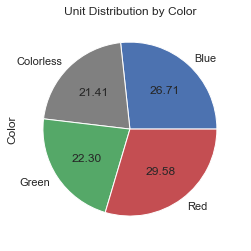

In [18]:
# See the number of characters for each color
sns.set()

colors = heroes.groupby(by="Color").agg(np.size).iloc[:, 6]
colors = colors.rename("Color")
colors.plot.pie(labels=['Blue', 'Colorless', 'Green', 'Red'], colors=['b', 'gray', 'g', 'r'], autopct='%.2f')
plt.title("Unit Distribution by Color")
plt.show()

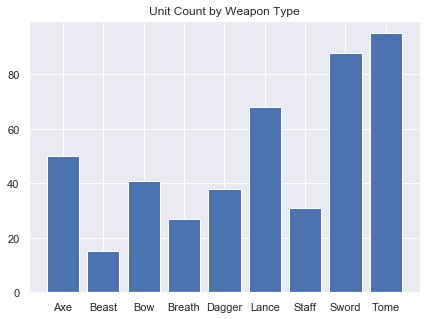

In [11]:
# See the number of characters for each weapon type
sns.set()
plt.figure(figsize=(7, 5))
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon Type").agg(np.size).iloc[:, 0], align = "center")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon Type").agg(np.size).index)
plt.title("Unit Count by Weapon Type")
plt.show()

We see that characters that use tomes are the most abundant in the game (barely beating out those who use swords). However, we should note that there are three different colors associated with tome users, while sword users are all red. Below we will show a distribution of the color of tome users.

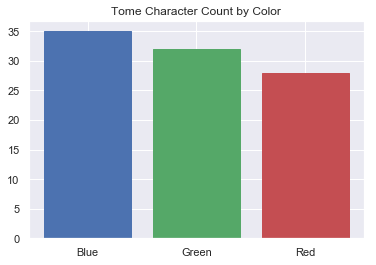

In [12]:
# Tome
tomebar = plt.bar([0, 1, 2], heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).iloc[:, 0], align = "center")
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Red")[0][0]].set_color('r')
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Blue")[0][0]].set_color('b')
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Green")[0][0]].set_color('g')
plt.xticks([0, 1, 2], heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index)
plt.title("Tome Character Count by Color")
plt.show()

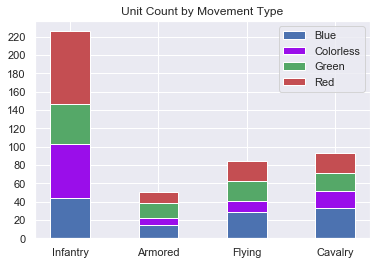

In [14]:
# See the number of characters for each movement type
sns.set()

mov_ty = ["Infantry", "Armored", "Flying", "Cavalry"]
inf = (heroes[heroes["Movement Type"] == mov_ty[0]].groupby(by = "Color").agg(np.size).iloc[:, 0])
arm = (heroes[heroes["Movement Type"] == mov_ty[1]].groupby(by = "Color").agg(np.size).iloc[:, 0])
fly = (heroes[heroes["Movement Type"] == mov_ty[2]].groupby(by = "Color").agg(np.size).iloc[:, 0])
cav = (heroes[heroes["Movement Type"] == mov_ty[3]].groupby(by = "Color").agg(np.size).iloc[:, 0])
inds = heroes[heroes["Movement Type"] == mov_ty[0]].groupby(by = "Color").agg(np.size).index
inds

zos = np.array((inf[0], arm[0], fly[0], cav[0]))
ones = np.array((inf[1], arm[1], fly[1], cav[1]))
twos = np.array((inf[2], arm[2], fly[2], cav[2]))
tres = np.array((inf[3], arm[3], fly[3], cav[3]))

ind = np.arange(4)    
width = 0.45      

p1 = plt.bar(ind, zos, width, color = "b")
p2 = plt.bar(ind, ones, width,  bottom=zos, color = "xkcd:violet")
p3 = plt.bar(ind, twos, width,  bottom= zos + ones, color = "g")
p4 = plt.bar(ind, tres, width, bottom = zos + ones + twos, color = "r")

plt.title("Unit Count by Movement Type")
plt.xticks(ind, ("Infantry", "Armored", "Flying", "Cavalry"))
plt.yticks(np.arange(0, np.sum(inf) + 10, 20))
plt.legend((p1[0], p2[0], p3[0], p4[0]), (inds))

plt.show()

#heroes.groupby(by = "Movement Type").agg(np.size).iloc[:, 0].groupby(by = "Color").agg(np.size).iloc[:, 0]

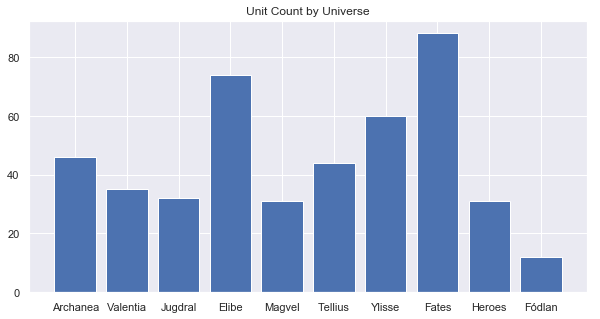

In [15]:
# See the number of characters for each universe
sns.set()

Universes = []

Archanea = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Mystery of the Emblem"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Shadow Dragon and the Blade of Light"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: New Mystery of the Emblem"])
Valentia = len(heroes.loc[heroes["Origin"] == "Fire Emblem Echoes: Shadows of Valentia"])
Jugdral = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Genealogy of the Holy War"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Thracia 776"])
Elibe = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Blazing Blade"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Binding Blade"])
Magvel = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Sacred Stones"])
Tellius = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Path of Radiance"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Radiant Dawn"])
Ylisse = len(heroes.loc[heroes["Origin"] == "Fire Emblem Awakening"])
Fates = len(heroes.loc[heroes["Origin"] == "Fire Emblem Fates"])
Heroes = len(heroes.loc[heroes["Origin"] == "Fire Emblem Heroes"])
threeH = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Three Houses"])
     
Universes.append(Archanea)
Universes.append(Valentia)
Universes.append(Jugdral)
Universes.append(Elibe)      
Universes.append(Magvel)
Universes.append(Tellius)
Universes.append(Ylisse)
Universes.append(Fates)
Universes.append(Heroes)
Universes.append(threeH)

plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), Universes, align = "center")
plt.xticks(np.arange(10), ["Archanea", "Valentia", "Jugdral", "Elibe", "Magvel", "Tellius", 
                          "Ylisse", "Fates", "Heroes", "Fódlan"])
plt.title("Unit Count by Universe")
plt.show()

The universes above correspond to the following games:

Archanea: _Fire Emblem: Shadow Dragon_ and _Fire Emblem: Mystery of the Emblem_  
Valentia: _Fire Emblem Gaiden_ / _Fire Emblem Echoes: Shadows of Valentia_  
Jugdral: _Fire Emblem: Geneology of the Holy War_ and _Fire Emblem Thracia 776_  
Elibe: _Fire Emblem: Binding Blade_ and _Fire Emblem: Blazing Sword_ (known as _Fire Emblem_ in the US)  
Magvel: _Fire Emblem: Sacred Stones_  
Tellius: _Fire Emblem: Path of Radiance_ and _Fire Emblem: Radiant Dawn_  
Ylisse: _Fire Emblem: Awakening_  
Fates: _Fire Emblem: Fates_  
Heroes: _Fire Emblem: Heroes_
Fódlan: _Fire Emblem: Three Houses_  

We can see that certain universes have noticeably higher representation in the game. Fates characters make up about close to 20% of the current total character count. Elibe (Blazing Sword and Binding Blade) and Awakening make up the rest of the top three. It is likely that popularity of the entries is related to character representation.

Fire Emblem: Three Houses was just recently released in July 2019, so it is likely more characters will be rolled out from that entry soon enough.

## Save to CSV

The cell below will save the data that we've scraped and processed into a .csv file that can be used for future analysis.

NOTE: because there is an updated version of this file using selenium, we will not be saving the data in this file.

In [31]:
#heroes.to_excel("hero_data.xlsx", encoding='utf-8', index=False)
#heroes["Name"].to_excel("tier_list.xlsx", encoding='utf-8', header = True)